# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

## Подготовка данных

Прежде чем рабодать с данными, импортируем необходимые инструменты.

In [1]:
!pip install scikit-learn -U -q


import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import (OneHotEncoder,
                                  RobustScaler)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (train_test_split,
                                    cross_val_score)

from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

try:
    import phik
except ModuleNotFoundError:
    !pip install phik -q
    import phik

try:
    import optuna
except ModuleNotFoundError:
    !pip install optuna
    import optuna

try:
    import category_encoders
except ModuleNotFoundError:
    !pip install category_encoders
    import category_encoders

from category_encoders import TargetEncoder
        
RANDOM_STATE = 42


pd.set_option('float_format', '{:,.3f}'.format)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

     |████████████████████████████████| 380 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 1.0 MB/s eta 0:00:011


Выполнив необходиме импорты, загрузим данные и ознакомимся с ними.

In [2]:
df = pd.read_csv('/datasets/autos.csv',sep=',', decimal='.')

In [3]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Всего в 4х полях присутвуют пропуски, это немгого. Часть парметров не столь важна, а часть бдует заполнять данными на наше усмотрение не очень корректно, поэтмоу от пропусков откажемся.

Переведем даты в соответсвующий формат и округ до дня.

In [4]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S').dt.round('D').dt.year
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').dt.round('D').dt.year
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S').dt.round('D').dt.year

In [5]:
df = df.dropna()

Проверим данные на предмет полных дубликатов.

In [6]:
df.duplicated().sum()


17119

Полые дубликаты есть, также откажется от них.

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Мы ознакомились с данными, обработали пропуски и избавились от дубликатов.

### Исследовательский анализ данных

Изучим данные более подробно. Для некоторых шагов поспользуемся фнукциями. 


#### Качественные показатели

In [8]:
def pie_chart(column, title):
    (df[column].value_counts()
     .plot(figsize=(7, 7), 
           kind='pie', 
           autopct='%1.2f%%',
           colors = sns.color_palette('pastel')[0:5],
           fontsize=13,
          ).set(title = title,
                ylabel = ''))
plt.show()

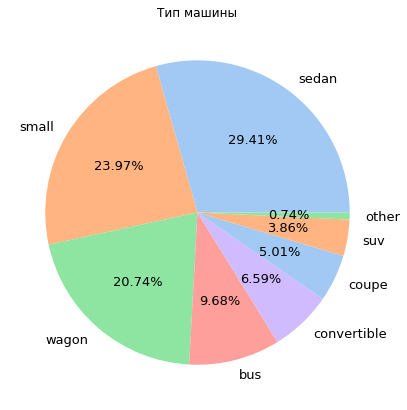

In [9]:
pie_chart(
    'VehicleType',
    f'Тип машины'
)

Практически 3/4 всех автомобилей представлены тремя категориями. А "других" всего менее одного процента.

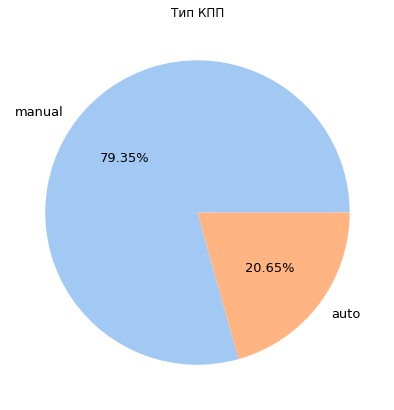

In [10]:
pie_chart(
    'Gearbox',
    f'Тип КПП'
)

Что интересно ~79.2% от всего машин на механичской коробкой переключения передач.

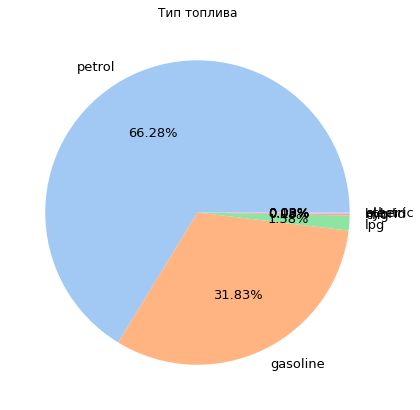

In [11]:
pie_chart(
    'FuelType',
    f'Тип топлива'
)

На бензине ездит всего !66% автомобилей из выборки, а еще почти ~32% газифицированы.

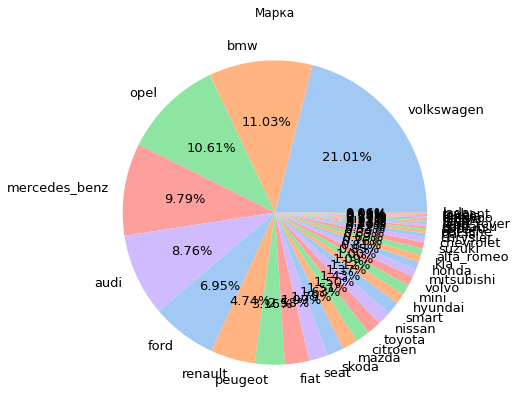

In [12]:
pie_chart(
    'Brand',
    f'Марка'
)

Марок представлено достаточно много. `volkswagen` занимает 21%, а в то время как `opel`, `mercedes`, `audi` занимают сопосотовимые 8-10%, доля даругих марок уже меньше.

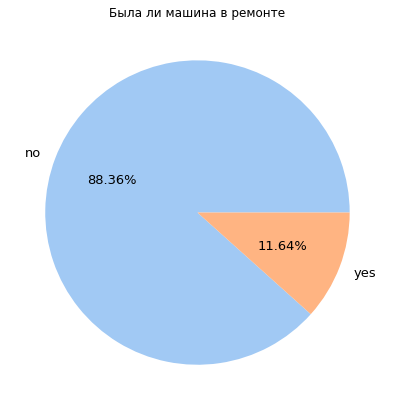

In [13]:
pie_chart(
    'Repaired',
    f'Была ли машина в ремонте'
)

88% автомобилей из выборки действительно не биты и не крашены т.к. в ремонте они не были.

#### Количественные показатели

Пора перейти к количесвтенным показтелям. К ним больше подойдут гистограммы для визулизации и последующего анализа.

Как в случае с даиграммами прибегнем к функции для большей читаемости.

In [14]:
def num_vis(col, xlabel, title):
    plt.figure(figsize=(17, 5))
    sns.set_theme(palette="pastel")
    sns.histplot(
        df[col],
        bins = 20
    ).set(
        title = title,
        xlabel = xlabel,
        ylabel = 'Количество авто')
    plt.show()

    plt.figure(figsize=(17, 3))
    sns.boxplot(
        df[col], 
        orient='h'
    ).set(
        title = title,
        xlabel = xlabel,
        )
    plt.show()
    
    display( df[col].describe())

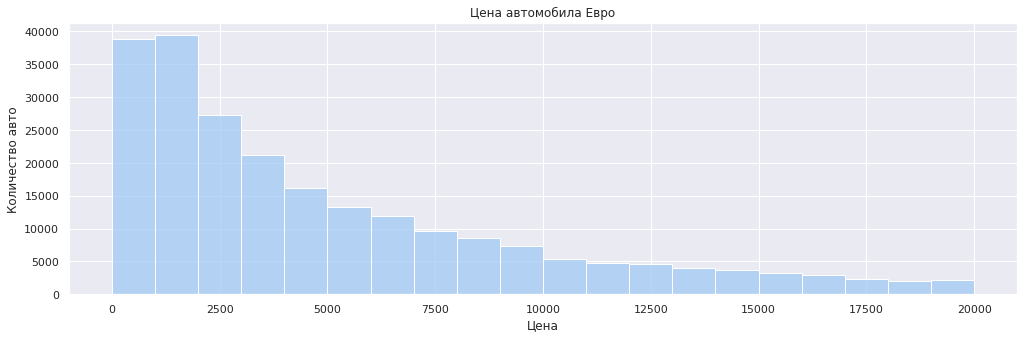

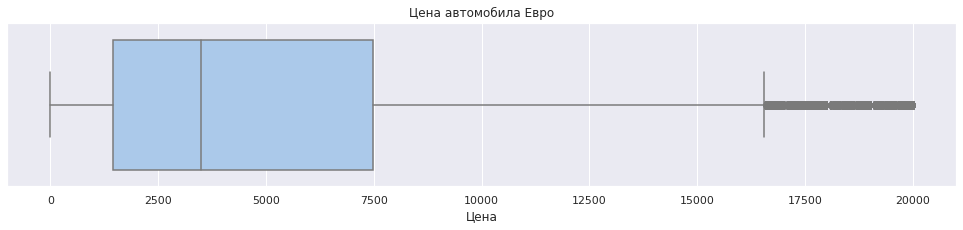

count   228,695.000
mean      5,095.010
std       4,714.172
min           0.000
25%       1,450.000
50%       3,499.000
75%       7,490.000
max      20,000.000
Name: Price, dtype: float64

In [15]:
num_vis(
    'Price', 
    'Цена',
    f'Цена автомобила Евро'
)

Некоторое количество выбросов вверх присутвует т.к. допустимы люксовые машины, которых мало. Ну левые цены это непарвильно, врдядли машина раздают беслпатно. Откажемся от занчений ниже 500 доларов.

In [16]:
df = df.loc[df['Price'] >= 250]

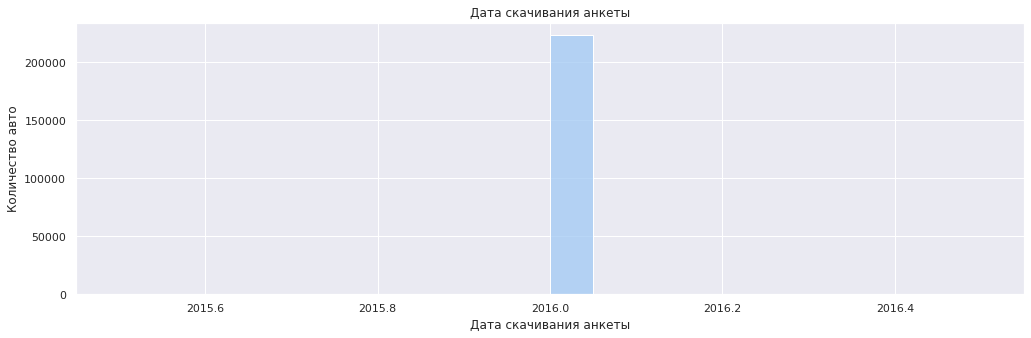

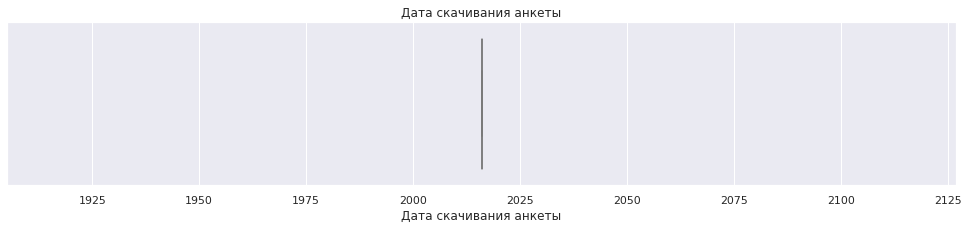

count   222,760.000
mean      2,016.000
std           0.000
min       2,016.000
25%       2,016.000
50%       2,016.000
75%       2,016.000
max       2,016.000
Name: DateCrawled, dtype: float64

In [17]:
num_vis(
    'DateCrawled', 
    'Дата скачивания анкеты',
    f'Дата скачивания анкеты'
)

Видим, что все анкеты скачены в 2016 году.

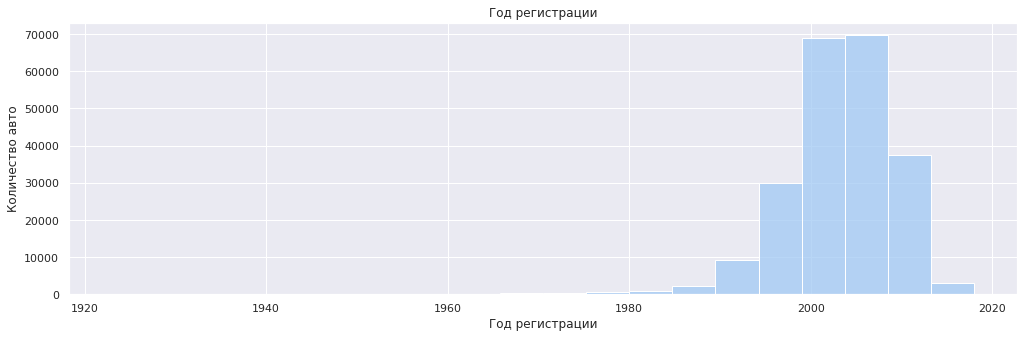

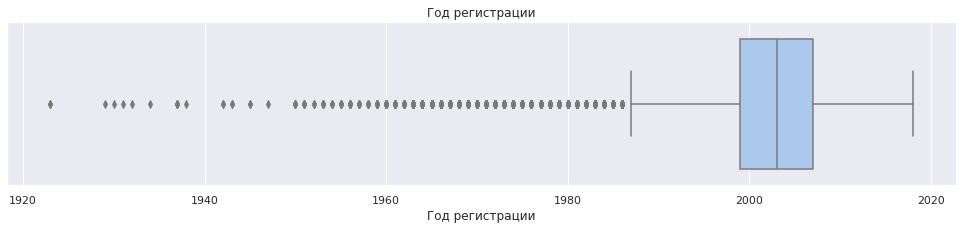

count   222,760.000
mean      2,002.992
std           6.140
min       1,923.000
25%       1,999.000
50%       2,003.000
75%       2,007.000
max       2,018.000
Name: RegistrationYear, dtype: float64

In [18]:
num_vis(
    'RegistrationYear', 
    'Год регистрации',
    f'Год регистрации'
)

Графики понятны и закономерны, по годам машины пристувуют от антикварных, до более свежих. Преобладают подерджаные машины из нулевых. Но машины старше 60-х это уже больше похоже на антиквариат, откажемся от них.

Также, год скаченивания анкеты 2016, но некотоыре магшины зраегистрированы в 2020. Не только лишь все могут смотерь сегодня в завтрашний день. Верхнюю границу зададим 2016 годом.

In [19]:
df = df.loc[(df['RegistrationYear'] >= 1960) & ((df['RegistrationYear'] <= 2016))]

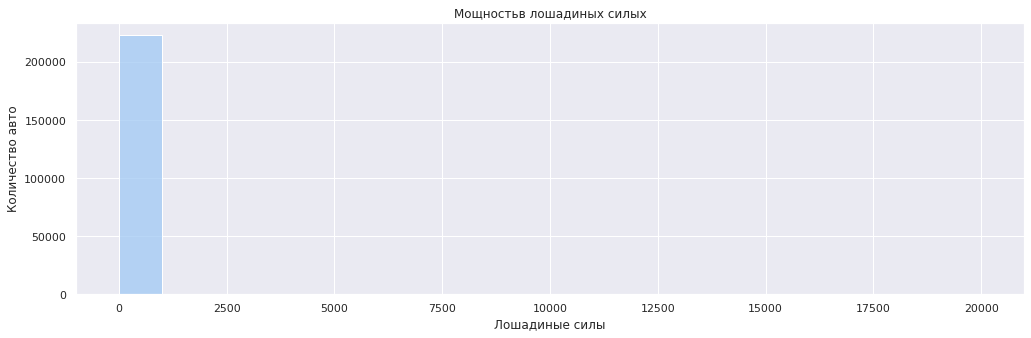

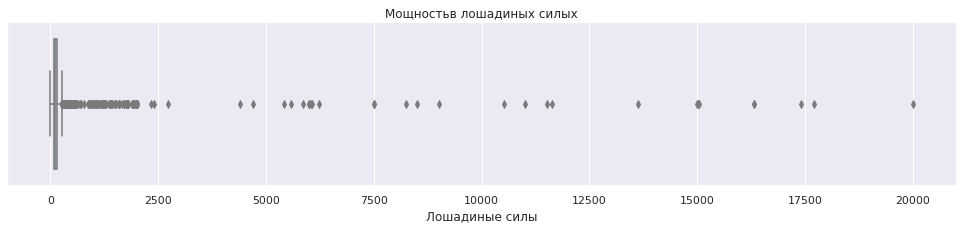

count   222,674.000
mean        120.513
std         141.028
min           0.000
25%          75.000
50%         113.000
75%         150.000
max      20,000.000
Name: Power, dtype: float64

In [20]:
num_vis(
    'Power', 
    'Лошадиные силы',
    f'Мощностьв лошадиных силых'
)

Настолько мощные в таком количестве выглядят очень сомнительно, откажемся от знаечний  в прелделах 1000 сил. Представив, что есть спортивные/люксовые машины в выборке.

In [21]:
df = df.loc[df['Power'] <= 1000]

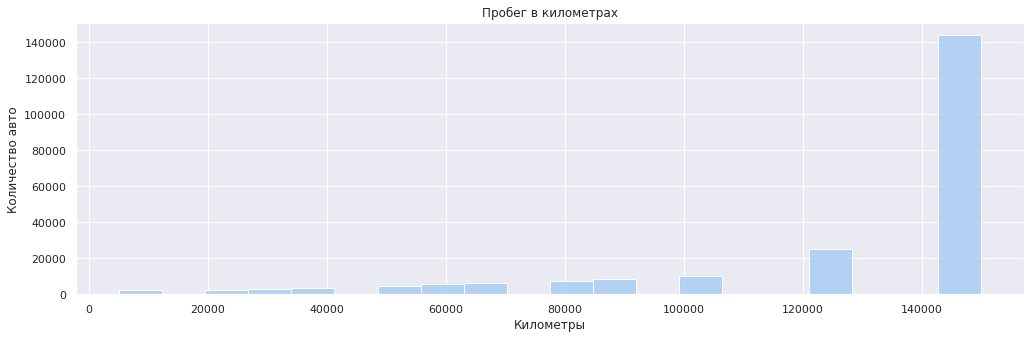

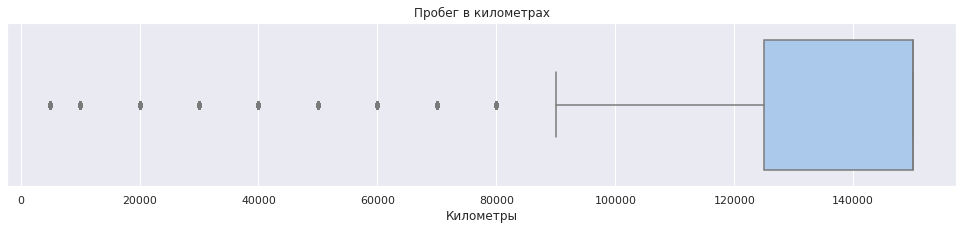

count   222,558.000
mean    127,277.272
std      36,975.641
min       5,000.000
25%     125,000.000
50%     150,000.000
75%     150,000.000
max     150,000.000
Name: Kilometer, dtype: float64

In [22]:
num_vis(
    'Kilometer', 
    'Километры',
    f'Пробег в километрах'
)

Подобная картина - не новость после графика по годам. В подборке у нас подержаные машины.

Осомтрив и очистив даные от аномалий, перед нами насыщенный список подержаных машин, прктически на любой вкус, цвет и кошелек.

#### Корреляционный анализ

Построим матрицы корреляции с использованием функционала библиотеки `phik`.

Не все даты, из датасета нам нужны, оставим только необходимые.

In [23]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'],axis = 1)

In [24]:
df.duplicated().sum()

1

Похоже, что в части строк уникальными была толкьо дата, значит анкеты/объявления по одниим и тем же машинам попадали в выгрузку каждый раз как с ним произвродилсь какие-либо манипулции.

In [25]:
df = df.drop_duplicates()
df.duplicated().sum()

0

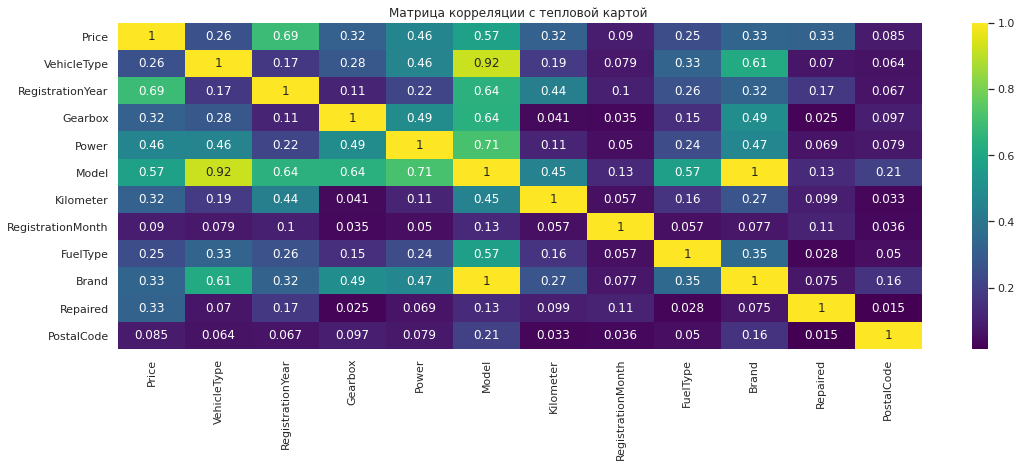

In [26]:
cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures', 'PostalCode']

plt.figure(figsize = (18, 6))
sns.heatmap(
        df.phik_matrix(interval_cols = cols),
    annot = True,
    cmap = 'viridis'
    )
plt.title(f'Матрица корреляции с тепловой картой '
        )
plt.show()

В данных нет сильнокорелирующих значений с целевым признаком. Есть наиболе корелирующие такие как возраст машины, ее модель и мощность, остальные признаки имеют схожую, менее выраженую корляцию. Месяц регистарции и почтовый индекс ожидаемо на цену не влияют. От послнедго откажемся

In [27]:
df = df.drop(['PostalCode'],axis = 1)

## Обучение моделей

Подготовим данные для передачи их в модель.

### Модели дерева принятия решений

In [28]:
#Разделим данные на на обучающую и валидационную выборки для стандартных моделей.
X_train_test, X_val, y_train_test, y_val = train_test_split(
    df.drop(["Price"], axis=1),
    df["Price"],
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_test,
    y_train_test,
    test_size=0.2,
    random_state=RANDOM_STATE
)

#Задаем списки столбцов для кодирования и масштабирования.
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Repaired']
big_num = ['Kilometer', 'Power']
trgt_columns = ['Model', 'Brand']

#Пайплайн подготовки признаков с помощью OneHotEncoder.
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(
                drop = 'first'
            )
        )
    ]
)



#Общий пайплайн подготовки данных.
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('trgt', TargetEncoder(), trgt_columns),
    ('big_num', RobustScaler(), big_num)
])

#Производим обучение.
data_preprocessor.fit(X_train, y_train)

#Создаем список с новыми названиями столбцов в датафреймах.
#new_columns = data_preprocessor.get_feature_names()

#Сохраняем кодированные и масштабированные данные.
X_train = pd.DataFrame(
    data_preprocessor.transform(X_train)
)

X_test = pd.DataFrame(
    data_preprocessor.transform(X_test)
)

X_val = pd.DataFrame(
    data_preprocessor.transform(X_val)
)

Теперь создаем пайплайн по поиску модели с оптимальными гиперпараметрами и запускаем его.

In [29]:
reg_models_pipe = Pipeline(
    [('models', DecisionTreeRegressor(random_state = RANDOM_STATE))]
)

# Словари для модели.
param_grid = [
    # Словарь для модели DecisionTreeRegressor().
    {
        'models' : [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth' : [3, 5, 15, 25],
        'models__max_features' : [3, 5, 10],
        'models__min_samples_split' : [3, 5, 10]
    },
]

# Задаем настройки поиска оптимальных параметров.
grid_search = GridSearchCV(
    reg_models_pipe,
    param_grid,
    scoring = 'neg_root_mean_squared_error'
)

# Производим поиск оптимальных параметров модели.
grid_search.fit(X_train, y_train)

# Выводим лучшую модель.
print(f"Лучшая модель и ее параметры:\n\n {grid_search.best_estimator_} \n\n")

Лучшая модель и ее параметры:

 Pipeline(steps=[('models',
                 DecisionTreeRegressor(max_depth=25, max_features=10,
                                       min_samples_split=10,
                                       random_state=42))]) 




Отлично, у нас есть оптимальные параметры модели и метрика для оптимальной класичсекой модели.

Перейдем к бустингу и поулчим те же данные, но для него.

### LGBM

Для работы с `lgbm` закодируем категориальные признаки в тип данных `category`, численные модель обработает сама.

In [30]:
categorical = [
    "VehicleType",
    "Gearbox",
    "FuelType",
    "Repaired",
    "RegistrationYear",
    "Model",
    "Brand",
    
]

for category in categorical:
    df[category] = df[category].astype("category").cat.codes

И перейдем непосредственно к поиску гиперпараметров.

In [31]:
#Разделим данные на на обучающую и валидационную выборки для модли бустинга.
X_train_test, X_val_lgb, y_train_test, y_val_lgb = train_test_split(
    df.drop(["Price"], axis=1),
    df["Price"],
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(
    X_train_test,
    y_train_test,
    test_size=0.2,
    random_state=RANDOM_STATE
)

lgb_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgb_val = lgb.Dataset(X_val_lgb, label=y_val_lgb, reference=lgb_train)

#Проведем подбор гиперпараметров через optuna
def objective(trial):
    params = {
         "metric": "rmse",
         "num_leaves": trial.suggest_int("num_leaves", 20, 70),
         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0, step=0.1),
         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0, step=0.1),
         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
         "force_row_wise": True,
         "verbose": 0,
         "random_state": RANDOM_STATE
     }
    
    gbm = lgb.train(
         params,
         lgb_train,
         valid_sets=[lgb_val], callbacks=[lgb.early_stopping(stopping_rounds=5)]
     )
     
    preds = gbm.predict(X_val_lgb)
    pred_labels = np.rint(preds)
    rmse = root_mean_squared_error(y_val_lgb, pred_labels)
    
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Number of finished trials: {len(study.trials)}")

print(f"Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
     print(f"    {key}: {value}")

[I 2024-05-28 18:14:16,327] A new study created in memory with name: no-name-a75535bc-d729-4470-9721-0c6892f21722


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1634.11


[I 2024-05-28 18:14:25,808] Trial 0 finished with value: 1634.1034118148802 and parameters: {'num_leaves': 45, 'feature_fraction': 0.9, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 5}. Best is trial 0 with value: 1634.1034118148802.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1613.93


[I 2024-05-28 18:14:36,806] Trial 1 finished with value: 1613.9299129613078 and parameters: {'num_leaves': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'bagging_freq': 1}. Best is trial 1 with value: 1613.9299129613078.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1611.11


[I 2024-05-28 18:14:46,710] Trial 2 finished with value: 1611.1094980274481 and parameters: {'num_leaves': 66, 'feature_fraction': 0.9, 'bagging_fraction': 0.5, 'bagging_freq': 5}. Best is trial 2 with value: 1611.1094980274481.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1632.14


[I 2024-05-28 18:14:58,306] Trial 3 finished with value: 1632.1403369660288 and parameters: {'num_leaves': 48, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 4}. Best is trial 2 with value: 1611.1094980274481.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.62


[I 2024-05-28 18:15:10,304] Trial 4 finished with value: 1597.6199390846882 and parameters: {'num_leaves': 68, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 3}. Best is trial 4 with value: 1597.6199390846882.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.73


[I 2024-05-28 18:15:22,517] Trial 5 finished with value: 1595.7348259220003 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1815.74


[I 2024-05-28 18:15:27,512] Trial 6 finished with value: 1815.7376401265371 and parameters: {'num_leaves': 25, 'feature_fraction': 0.4, 'bagging_fraction': 0.5, 'bagging_freq': 6}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1630.62


[I 2024-05-28 18:15:36,212] Trial 7 finished with value: 1630.620792930131 and parameters: {'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 1}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1625.16


[I 2024-05-28 18:15:46,607] Trial 8 finished with value: 1625.1578988568313 and parameters: {'num_leaves': 57, 'feature_fraction': 1.0, 'bagging_fraction': 0.4, 'bagging_freq': 1}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1625.56


[I 2024-05-28 18:15:56,907] Trial 9 finished with value: 1625.563298312782 and parameters: {'num_leaves': 49, 'feature_fraction': 0.5, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1659.82


[I 2024-05-28 18:16:05,814] Trial 10 finished with value: 1659.819500825019 and parameters: {'num_leaves': 30, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 7}. Best is trial 5 with value: 1595.7348259220003.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.65


[I 2024-05-28 18:16:13,912] Trial 11 finished with value: 1592.6530216233934 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 11 with value: 1592.6530216233934.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:16:20,916] Trial 12 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1603.86


[I 2024-05-28 18:16:29,409] Trial 13 finished with value: 1603.8621216031097 and parameters: {'num_leaves': 60, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1640.06


[I 2024-05-28 18:16:35,701] Trial 14 finished with value: 1640.0635286850181 and parameters: {'num_leaves': 39, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1610.16


[I 2024-05-28 18:16:46,514] Trial 15 finished with value: 1610.1589163329543 and parameters: {'num_leaves': 56, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1601.42


[I 2024-05-28 18:16:59,805] Trial 16 finished with value: 1601.4146619979829 and parameters: {'num_leaves': 64, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1648.66


[I 2024-05-28 18:17:06,018] Trial 17 finished with value: 1648.6601701519323 and parameters: {'num_leaves': 36, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1612.49


[I 2024-05-28 18:17:15,804] Trial 18 finished with value: 1612.4879148241112 and parameters: {'num_leaves': 55, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1602.43


[I 2024-05-28 18:17:26,304] Trial 19 finished with value: 1602.4348985899824 and parameters: {'num_leaves': 64, 'feature_fraction': 0.8, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1600.89


[I 2024-05-28 18:17:37,807] Trial 20 finished with value: 1600.8936572418756 and parameters: {'num_leaves': 70, 'feature_fraction': 0.5, 'bagging_fraction': 0.9, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.73


[I 2024-05-28 18:17:47,818] Trial 21 finished with value: 1595.7348259220003 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1601.13


[I 2024-05-28 18:17:55,003] Trial 22 finished with value: 1601.1341191735862 and parameters: {'num_leaves': 62, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.52


[I 2024-05-28 18:18:06,013] Trial 23 finished with value: 1598.5205637888614 and parameters: {'num_leaves': 70, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.98


[I 2024-05-28 18:18:15,809] Trial 24 finished with value: 1597.9851142441767 and parameters: {'num_leaves': 65, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1615.31


[I 2024-05-28 18:18:24,012] Trial 25 finished with value: 1615.3080118311523 and parameters: {'num_leaves': 53, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1613.01


[I 2024-05-28 18:18:33,610] Trial 26 finished with value: 1613.005633863128 and parameters: {'num_leaves': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.19


[I 2024-05-28 18:18:44,214] Trial 27 finished with value: 1599.1872635400207 and parameters: {'num_leaves': 66, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1629.16


[I 2024-05-28 18:18:51,713] Trial 28 finished with value: 1629.161981661435 and parameters: {'num_leaves': 43, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1623.62


[I 2024-05-28 18:19:00,216] Trial 29 finished with value: 1623.6209838395998 and parameters: {'num_leaves': 52, 'feature_fraction': 0.9, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1603.91


[I 2024-05-28 18:19:10,803] Trial 30 finished with value: 1603.9080763510347 and parameters: {'num_leaves': 67, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.73


[I 2024-05-28 18:19:22,513] Trial 31 finished with value: 1595.7348259220003 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1604.15


[I 2024-05-28 18:19:32,405] Trial 32 finished with value: 1604.1570703596312 and parameters: {'num_leaves': 61, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.51


[I 2024-05-28 18:19:42,616] Trial 33 finished with value: 1595.511774956544 and parameters: {'num_leaves': 68, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1610.18


[I 2024-05-28 18:19:52,911] Trial 34 finished with value: 1610.179252498067 and parameters: {'num_leaves': 63, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1602.72


[I 2024-05-28 18:20:02,305] Trial 35 finished with value: 1602.7209633925747 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1608.54


[I 2024-05-28 18:20:11,106] Trial 36 finished with value: 1608.542651758715 and parameters: {'num_leaves': 59, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.69


[I 2024-05-28 18:20:22,804] Trial 37 finished with value: 1599.693216012607 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 7}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1613.18


[I 2024-05-28 18:20:33,212] Trial 38 finished with value: 1613.1823721139333 and parameters: {'num_leaves': 58, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1603.22


[I 2024-05-28 18:20:42,714] Trial 39 finished with value: 1603.214466552694 and parameters: {'num_leaves': 63, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1618.86


[I 2024-05-28 18:20:53,703] Trial 40 finished with value: 1618.861333470736 and parameters: {'num_leaves': 68, 'feature_fraction': 1.0, 'bagging_fraction': 0.4, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.73


[I 2024-05-28 18:21:04,116] Trial 41 finished with value: 1595.7348259220003 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.57


[I 2024-05-28 18:21:15,020] Trial 42 finished with value: 1594.5712107855752 and parameters: {'num_leaves': 68, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1603.21


[I 2024-05-28 18:21:26,410] Trial 43 finished with value: 1603.2050275400832 and parameters: {'num_leaves': 65, 'feature_fraction': 0.8, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.69


[I 2024-05-28 18:21:37,411] Trial 44 finished with value: 1598.691725546341 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1655.49


[I 2024-05-28 18:21:43,216] Trial 45 finished with value: 1655.4922710843073 and parameters: {'num_leaves': 30, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1605.66


[I 2024-05-28 18:21:52,515] Trial 46 finished with value: 1605.6585218597982 and parameters: {'num_leaves': 61, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.75


[I 2024-05-28 18:22:03,709] Trial 47 finished with value: 1594.747195143495 and parameters: {'num_leaves': 68, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1621.83


[I 2024-05-28 18:22:09,918] Trial 48 finished with value: 1621.8277877206954 and parameters: {'num_leaves': 46, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1602.14


[I 2024-05-28 18:22:20,216] Trial 49 finished with value: 1602.1445135094411 and parameters: {'num_leaves': 68, 'feature_fraction': 0.5, 'bagging_fraction': 0.9, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1601.8


[I 2024-05-28 18:22:28,602] Trial 50 finished with value: 1601.8000730660513 and parameters: {'num_leaves': 65, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1700.97


[I 2024-05-28 18:22:36,211] Trial 51 finished with value: 1700.9654398385528 and parameters: {'num_leaves': 20, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.75


[I 2024-05-28 18:22:47,306] Trial 52 finished with value: 1594.747195143495 and parameters: {'num_leaves': 68, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.75


[I 2024-05-28 18:22:59,616] Trial 53 finished with value: 1594.747195143495 and parameters: {'num_leaves': 68, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.96


[I 2024-05-28 18:23:10,406] Trial 54 finished with value: 1599.960406696661 and parameters: {'num_leaves': 65, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1604.99


[I 2024-05-28 18:23:21,814] Trial 55 finished with value: 1604.992221148433 and parameters: {'num_leaves': 63, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9, 'bagging_freq': 6}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.65


[I 2024-05-28 18:23:30,006] Trial 56 finished with value: 1592.6530216233934 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 5}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.52


[I 2024-05-28 18:23:38,507] Trial 57 finished with value: 1592.5130584891551 and parameters: {'num_leaves': 69, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.3


[I 2024-05-28 18:23:46,305] Trial 58 finished with value: 1594.302411002177 and parameters: {'num_leaves': 69, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.56


[I 2024-05-28 18:23:56,309] Trial 59 finished with value: 1599.5650901913327 and parameters: {'num_leaves': 70, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1750.7


[I 2024-05-28 18:24:04,014] Trial 60 finished with value: 1750.6979716566752 and parameters: {'num_leaves': 56, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.51


[I 2024-05-28 18:24:12,403] Trial 61 finished with value: 1595.5053609022643 and parameters: {'num_leaves': 66, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 4}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.65


[I 2024-05-28 18:24:21,413] Trial 62 finished with value: 1592.6530216233934 and parameters: {'num_leaves': 70, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.3


[I 2024-05-28 18:24:30,107] Trial 63 finished with value: 1594.302411002177 and parameters: {'num_leaves': 69, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.56


[I 2024-05-28 18:24:38,501] Trial 64 finished with value: 1599.5650901913327 and parameters: {'num_leaves': 70, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.74


[I 2024-05-28 18:24:46,301] Trial 65 finished with value: 1599.7458158059715 and parameters: {'num_leaves': 64, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.82


[I 2024-05-28 18:24:56,212] Trial 66 finished with value: 1594.8236219789205 and parameters: {'num_leaves': 70, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 3}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.51


[I 2024-05-28 18:25:04,103] Trial 67 finished with value: 1595.5053609022643 and parameters: {'num_leaves': 66, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.52


[I 2024-05-28 18:25:12,013] Trial 68 finished with value: 1592.5130584891551 and parameters: {'num_leaves': 69, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1601.13


[I 2024-05-28 18:25:23,907] Trial 69 finished with value: 1601.1341191735862 and parameters: {'num_leaves': 62, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1634.03


[I 2024-05-28 18:25:31,916] Trial 70 finished with value: 1634.0295618514108 and parameters: {'num_leaves': 40, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.52


[I 2024-05-28 18:25:40,312] Trial 71 finished with value: 1592.5130584891551 and parameters: {'num_leaves': 69, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.63


[I 2024-05-28 18:25:47,802] Trial 72 finished with value: 1594.6309401489655 and parameters: {'num_leaves': 66, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.52


[I 2024-05-28 18:25:55,712] Trial 73 finished with value: 1592.5130584891551 and parameters: {'num_leaves': 69, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1599.25


[I 2024-05-28 18:26:04,918] Trial 74 finished with value: 1599.2534896871725 and parameters: {'num_leaves': 64, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1594.63


[I 2024-05-28 18:26:14,201] Trial 75 finished with value: 1594.6309401489655 and parameters: {'num_leaves': 66, 'feature_fraction': 0.7000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:26:23,712] Trial 76 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1611.96


[I 2024-05-28 18:26:34,515] Trial 77 finished with value: 1611.9584356312453 and parameters: {'num_leaves': 62, 'feature_fraction': 0.8, 'bagging_fraction': 0.5, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1646.49


[I 2024-05-28 18:26:40,911] Trial 78 finished with value: 1646.4900282152398 and parameters: {'num_leaves': 34, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:26:49,214] Trial 79 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.7


[I 2024-05-28 18:26:58,403] Trial 80 finished with value: 1598.6987703058917 and parameters: {'num_leaves': 59, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:27:06,106] Trial 81 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.7


[I 2024-05-28 18:27:13,502] Trial 82 finished with value: 1598.6986024266646 and parameters: {'num_leaves': 67, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:27:23,115] Trial 83 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:27:31,208] Trial 84 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.68


[I 2024-05-28 18:27:39,013] Trial 85 finished with value: 1597.6821360994566 and parameters: {'num_leaves': 65, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.7


[I 2024-05-28 18:27:47,505] Trial 86 finished with value: 1598.6986024266646 and parameters: {'num_leaves': 67, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.17


[I 2024-05-28 18:27:55,910] Trial 87 finished with value: 1598.1723750227213 and parameters: {'num_leaves': 69, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.72


[I 2024-05-28 18:28:03,504] Trial 88 finished with value: 1597.7260086100948 and parameters: {'num_leaves': 64, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1617.44


[I 2024-05-28 18:28:11,001] Trial 89 finished with value: 1617.4431721605997 and parameters: {'num_leaves': 50, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1593.04


[I 2024-05-28 18:28:19,715] Trial 90 finished with value: 1593.0387792480678 and parameters: {'num_leaves': 68, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:28:27,713] Trial 91 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1592.13


[I 2024-05-28 18:28:35,804] Trial 92 finished with value: 1592.1266170572276 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.58


[I 2024-05-28 18:28:43,506] Trial 93 finished with value: 1595.5824587398765 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.23


[I 2024-05-28 18:28:54,213] Trial 94 finished with value: 1597.226346640903 and parameters: {'num_leaves': 66, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.79


[I 2024-05-28 18:29:04,909] Trial 95 finished with value: 1597.7939959477567 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.58


[I 2024-05-28 18:29:13,213] Trial 96 finished with value: 1595.5824587398765 and parameters: {'num_leaves': 67, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1597.72


[I 2024-05-28 18:29:21,502] Trial 97 finished with value: 1597.7260086100948 and parameters: {'num_leaves': 64, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1598.92


[I 2024-05-28 18:29:29,315] Trial 98 finished with value: 1598.9257712780084 and parameters: {'num_leaves': 69, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'bagging_freq': 2}. Best is trial 12 with value: 1592.1266170572276.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.34


[I 2024-05-28 18:29:37,711] Trial 99 finished with value: 1595.3394412912357 and parameters: {'num_leaves': 68, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 1}. Best is trial 12 with value: 1592.1266170572276.


Number of finished trials: 100
Best trial:
  Params: 
    num_leaves: 69
    feature_fraction: 0.8
    bagging_fraction: 1.0
    bagging_freq: 3


При помощи `optuna` поулчилось подобрать гиперпараметры, чтобы уменьшить метрику на этапе обучения. `RMSE`= 1592.12. Это ощутимое улучшение метрики. 

Мы обучили првоели подобор гиперпатметров для моедли бустинга, полдобрали оптимальную класическую модель и гиперпараметры к ней, опираясь на скоринг и метрику по `RMSE`.

## Анализ моделей

По работе на валидационной выборке оценим метрику и время для обученяи и предсказания, котоыре выдают модели.

In [32]:
# Обучим лучшую модель на валидацйионно выборке выборке
model = grid_search.best_estimator_

y_predict_val = model.predict(X_val)

print(
    f"Метрика RMSE лучшей модели на валидационной выборке: "
    f"{root_mean_squared_error(y_val, y_predict_val):,.2f}.\n\n",
    
    f"Время обучения лучшей модели: "
    f"{abs(grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]):,.2f} мс",
    end=".\n\n",
)

Метрика RMSE лучшей модели на валидационной выборке: 2,317.85.

 Время обучения лучшей модели: 0.17 мс.



In [33]:
%%time
y_predict_val = model.predict(X_val)

print(
        f"Время предсказания лучшей модели: \n\n "
)

Время предсказания лучшей модели: 

 
CPU times: user 13.2 ms, sys: 17 µs, total: 13.2 ms
Wall time: 11.9 ms


Обучение дерева решений и его предскзание заняли буквально мнгновение, что впечатляет. `RMSE` на валидационной выборке оказался 2,317.85
Поосмтрим как справится бустинг.

In [34]:
%%time
params = {
    "metric": "rmse",
    "num_leaves": 70,
    "feature_fraction": 0.6,
    "bagging_fraction": 0.9,
    "bagging_freq": 3,
    "force_row_wise": True,
    "verbose": 0,
    "random_state": RANDOM_STATE
}

evals_result={}

model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),
        lgb.record_evaluation(evals_result)
    ]
)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1595.95
CPU times: user 10.3 s, sys: 60.9 ms, total: 10.4 s
Wall time: 10.3 s


In [35]:
%%time
y_predict_lgb_val = model_lgb.predict(
    X_val_lgb,
    num_iteration=model_lgb.best_iteration
)

print(
    f"Метрика RMSE лучшей модели на валидационной выборке: "
    f"{root_mean_squared_error(y_val_lgb, y_predict_lgb_val):,.2f}",
    end=".\n\n",
)

Метрика RMSE лучшей модели на валидационной выборке: 1,595.95.

CPU times: user 463 ms, sys: 3.26 ms, total: 467 ms
Wall time: 497 ms


При помощи `optuna` получилось подобрать гиперпараметры к модели таким образом, чтобы снизить ошибку. `RMSE`= 1,595.95. Это значительное улучшение метрики в сравнении с класичсеким деревом. Модель обучается значительно дольше, в разы. На нашей размерности данных это не критичная разница, если смотреть на абсолютные значения, но на бОльших данных это может иметь значение.

Псольку время работы в абсолютных значениях занимает мало времни, и роли значительной разницы не имеет, то руководствуясь метрикой, которая ощутимо отличается, основим свой выбор на модели бустинга.\
Обучим модель на тестовых данных и взглянем на финальную метрику.

In [36]:
%%time
y_predict = model_lgb.predict(
    X_test_lgb,
    num_iteration=model_lgb.best_iteration
)

print(
    f"Метрика RMSE лучшей модели на тестовой выборке: "
    f"{root_mean_squared_error(y_test_lgb, y_predict):,.2f}",
    end=".\n\n",
)

Метрика RMSE лучшей модели на тестовой выборке: 1,607.60.

CPU times: user 398 ms, sys: 0 ns, total: 398 ms
Wall time: 486 ms


Финальаня метрика на тестовых данных для лучией моедли, которой оказался градиентый бустинг 1,607.60.

По предскаазанию, как и обучению, схожая картина - классическая модель считает быстрее в разы, но в абсолютных значениях, в нашем случае не имеет большой разницы

## Итоговые выводы

Была посталвена задча по определнию рыночной стоимость автомобиля, на вход были данные с параметрами авто. При предсказании особое внимание удалялось таким критериям как: качество предсказания, время обучения модели, время предсказания модели.

Провели стандартный EDA, в ходе которого исследовали параметры более подробно, обработав и прроанализироов, в некоторых из них отселки выбросы.

На этапе кореляционного анализа првоерили данные на утечку целевого признака и мултиколенеарность. Выявили наиболее влияющие на цену паарметры (которые открытием не стали). 

Для обучения стандартных моделей выбрали деерво решений к которому перебирали гиперпарметры через `GridSearch` и линейную регрессию. Лушие результаты показало дерево.

Для модели бутинга гиперпараметры подбирали через `optuna`, что заняло боьше времени, чем подобор гиперпаметров для обычной модели, зато получилось их подобрать достаточно точно и улучшить метрику.

При анализе моделей на каждом этапе тенденция сохранлась, бустинг проводит вычисления дольше, но за счет этого получилось сократить метрику, что говорит об увлечении точности предсказаний модели. Самый долгий этап - подобор гипрепаметров проходит вне заказчика, абсолютные заначеняи времени на обучение и предсказания не велики, с учетом того и значителнього улучшения метрики, бустинг - лучшая модель в данном случае.